<a href="https://colab.research.google.com/github/JosephDonoso/ADA-Informes/blob/main/Informe_Bellman_Ford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Informe Algoritmo de Bellman-Ford**

## **1. Problema: Camino más corto con fuente única**


> El algoritmo recibirá un grafo dirigido, en el cual cada arco tendrá un peso real. Tiene por objetivo calcular la menor distancia desde un nodo fuente $s$ a cada nodo $v$ del grafo, o bien indicar si en este existe un ciclo infinito.

**Entrada**: Un grafo dirigido $G=(V,E)$, un vértice fuente $s\in V$, y un valor real $l_e$ asociado a cada arco $e\in E$.

**Salida**: Una de las siguientes opciones:

1. La distancia más corta $dist(s,v)$ para cada vértice $v\in V$.
2. Una declaración indicando que $G$ contiene un ciclo negativo.

## **2. Algoritmo Bellman-Ford**

### **2.1. Descripción del algoritmo**

Como se explicó anteriormente, el algoritmo de Bellman-Ford es una solución para el famoso problema del **camino más corto de única fuente**, que se describe como el problema de encontrar la ruta que minimice el costo (suma de los arcos involucrados en la ruta) de recorrer desde un vértice origen a todos los demás vértices del grafo. El mismo problema es propuestos en diversas situaciones, como por ejemplo el costo mínimo que podemos conseguir en recorrer una serie de servidores web, la ruta más corta de una ciudad a otra o una secuencia de transacciones de ventas y compras para obtener el mayor beneficio posible.

Además de este algoritmo existen muchos otros que entregan una solución a problemas de este estilo, como el algoritmo de Dijkstra que resuleve el problema del camino más corto de fuente única para arcos con peso positivo o el algoritmo de Floyd-Warshall que funciona con pesos reales y retorna una matriz de longitudes para encontrar el camino más corto de cada par de vértices.

El algoritmo funciona de la siguiente forma, si queremos encontrar la distancia más corta desde un nodo $s$ a un nodo $v$ recorriendo una cantidad de $i$ arcos, un problema que llamaremos $P$, lo podremos subdividir en un problema más pequeño $P'$ que se describirá en encontrar la ruta óptima entre el nodo $s$ y un nodo intermedio $w$ recorriendo en este caso $i-1$, y sumarle la distancia que existe entre $w$ y $v$. Se representará en la siguiente subestructura óptima obtenida de los apuntes de clase:

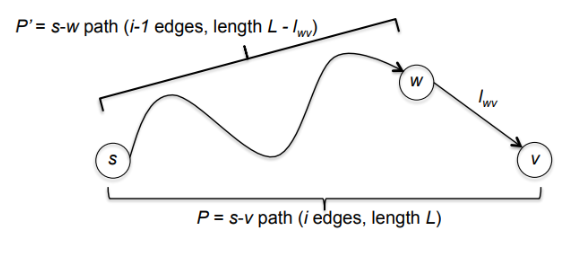

Pero que ocurre si desconocemos la cantidad de arcos que tiene la ruta óptima de $s$ a $v$, lo que podemos hacer es considerar que el camino más corto puede tener a los $i$ primeros arcos **o menos**. Es decir, el camino más corto de $s$ a $v$ con $i$ arcos puede ser:


1.   El camino más corto de $s$ a $v$ con $i-1$ arcos.
2.   O el camino más corto de $s$ a $w$ con $i-1$ arcos más la distancia de $w$ a $v$.

De lo anterior se puede conformar una función de recurrencia para recrear la solución al problema original:


Consideremos como $L_{i,v}$ el largo mínimo de un camino $s$ a $v$ con a lo más $i-1$ arcos. Luego, para todo $i\geq 1$ y $v \in V$ tenemos que:

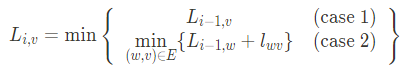

Ahora que ocurre cuando $i = 0$. A continuación se describirán los casos bases:

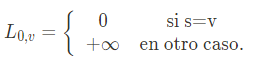

Donde para $i = 0$ arcos considerados, pueden ocurrir dos situaciones:


1.   Cuando $s$ y $v$ del subproblema actual son el mismo nodo, entonces para cero arcos la distancia que existe del origen a sí mismo es de coste 0. 
2.   En cambio, cuando $s$ y $v$ son dos nodos distintos, lo que ocurre al considerar 0 arcos es que estos nodos nunca podrán ser alcanzables entre sí, por lo que su coste es de **infinito**, lo mismo sucede con la distancia entre dos nodos sin conexion directa.



### **2.2. Implementación del algoritmo**

#### **Librerías**

In [338]:
import random
import networkx as nx
import numpy as np
from collections import defaultdict
import sys
import matplotlib.pyplot as plt
import datetime
from timeit import repeat

#### **Generador de instancias**

In [339]:
def is_valid_edge(generated_edges: dict, i: int, j: int):
    return i != j and not generated_edges.get((i, j), None) and not generated_edges.get((j, i), None)

def instance_generator(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = random.sample(range(0, n), n)
    unvisited_nodes = random.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = random.sample(nodes, random.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, random.randint(-25, 100)) #-25 100
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = random.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, random.randint(-25, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = random.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, random.randint(-25, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator(n)

    return graph, graph[0][0]

In [340]:
def positive_instance_generator(n: int):
    """
        Input: cantidad de vértices
        Output: una lista que contiene todos los arcos y el número del vértice fuente (la función retorna dos variables).
        Los arcos vienen en la forma (i, j, weight), donde i es el vértice origen del arco y j el vértice al que apunta el arco, mientras que weight es su peso.
    """
    graph = []
    nodes = random.sample(range(0, n), n)
    unvisited_nodes = random.sample(range(0, n), n)
    
    generated_edges = {}
    for i in nodes:
        rand = random.sample(nodes, random.randint(1, 3))

        for j in rand:
            edge = (i, j)
            edge_with_weight = (i, j, random.randint(0, 100)) #-25 100
            
            if generated_edges.get((edge[1], edge[0]), None):
                continue
            
            if i == j:
                new_vertice = None
                iterations = 0
                while new_vertice is None and iterations < 250:
                    iterations += 1
                    number = random.randint(0, n - 1)
                    if is_valid_edge(generated_edges, i, number):
                        new_vertice = number

                if iterations >= 250:
                    return instance_generator(n)
                
                edge = (i, new_vertice)
                edge_with_weight = (i, new_vertice, random.randint(0, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
            
            graph.append(edge_with_weight)
            generated_edges[edge] = edge

            if edge_with_weight[1] in unvisited_nodes:
                unvisited_nodes.remove(edge_with_weight[1])

    for i in unvisited_nodes:
        valid_edge = False
        iterations = 0
        while not valid_edge and iterations < 250:
            iterations += 1
            m = random.randint(0, n - 1)
            if is_valid_edge(generated_edges, m, i):
                valid_edge = True
                edge = (m, i)
                edge_with_weight = (m, i, random.randint(0, 100)) # -25 y 100 corresponde a los límites de los pesos, puede cambiarlos.
                graph.append(edge_with_weight)
                generated_edges[edge] = edge

        if iterations >= 250:
            return instance_generator(n)

    return graph, graph[0][0]

In [341]:
print(instance_generator(3))

([(2, 0, 87), (0, 1, -12), (1, 2, 52)], 2)


#### **Convertidor de grafos a DiGraph**

In [342]:
def graph_to_nxdigraph(graph: list, n: int):
    """
        Input: Un grafo en formato list[tuple]. Ej: [(0, 1, 10), (1, 2, 15), (2, 0, 7)].
        Output: Un nx.DiGraph de la libreria networkx.
    """
    nxdigraph = nx.DiGraph()
    [nxdigraph.add_node(i) for i in range(n)]

    for v in graph:
        nxdigraph.add_edge(v[0], v[1], weight=v[2])

    return nxdigraph

Nodo fuente: 3


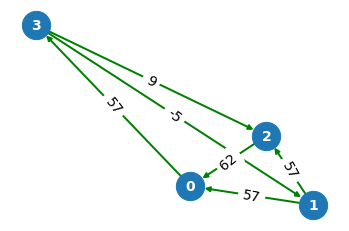

In [343]:
graph, n = instance_generator(4)
digraph = graph_to_nxdigraph(graph, 4)
pos = nx.spring_layout(digraph)
labels = nx.get_edge_attributes(digraph,'weight')
nx.draw_networkx_edge_labels(digraph,pos,edge_labels=labels,font_size=14)
nx.draw(digraph, pos, with_labels=True, node_size=800, font_color="white", font_size=14, font_weight="black", width  =2.0, edge_color ="green")
print("Nodo fuente:", n)

#### **Cola de prioridad**

In [344]:
#Cola de prioridad
class Heap():

  def __init__(self):
    self.array = []
    self.size = 0
    self.pos = []

  def newMinHeapNode(self, v, dist):
    minHeapNode = [v, dist]
    return minHeapNode

  # A utility function to swap two nodes
  # of min heap. Needed for min heapify
  def swapMinHeapNode(self, a, b):
    t = self.array[a]
    self.array[a] = self.array[b]
    self.array[b] = t

  # A standard function to heapify at given idx
  # This function also updates position of nodes
  # when they are swapped.Position is needed
  # for decreaseKey()
  def minHeapify(self, idx):
    smallest = idx
    left = 2*idx + 1
    right = 2*idx + 2

    if (left < self.size and
    self.array[left][1]
      < self.array[smallest][1]):
      smallest = left

    if (right < self.size and
    self.array[right][1]
      < self.array[smallest][1]):
      smallest = right

    # The nodes to be swapped in min
    # heap if idx is not smallest
    if smallest != idx:

      # Swap positions
      self.pos[self.array[smallest][0]] = idx
      self.pos[self.array[idx][0]] = smallest

      # Swap nodes
      self.swapMinHeapNode(smallest, idx)

      self.minHeapify(smallest)

  # Standard function to extract minimum
  # node from heap
  def extractMin(self):

    # Return NULL wif heap is empty
    if self.isEmpty() == True:
      return

    # Store the root node
    root = self.array[0]

    # Replace root node with last node
    lastNode = self.array[self.size - 1]
    self.array[0] = lastNode

    # Update position of last node
    self.pos[lastNode[0]] = 0
    self.pos[root[0]] = self.size - 1

    # Reduce heap size and heapify root
    self.size -= 1
    self.minHeapify(0)

    return root

  def isEmpty(self):
    return True if self.size == 0 else False

  def decreaseKey(self, v, dist):

    # Get the index of v in heap array

    i = self.pos[v]

    # Get the node and update its dist value
    self.array[i][1] = dist

    # Travel up while the complete tree is
    # not heapified. This is a O(Logn) loop
    while (i > 0 and self.array[i][1] <
        self.array[(i - 1) // 2][1]):

      # Swap this node with its parent
      self.pos[ self.array[i][0] ] = (i-1)//2
      self.pos[ self.array[(i-1)//2][0] ] = i
      self.swapMinHeapNode(i, (i - 1)//2 )

      # move to parent index
      i = (i - 1) // 2;

  # A utility function to check if a given
  # vertex 'v' is in min heap or not
  def isInMinHeap(self, v):

    if self.pos[v] < self.size:
      return True
    return False

#### **Funciones para grafos de tipo Dijkstra (diccionario de tuplas "fuente : (vértice,peso)" )**

In [345]:
#Printear solución
def printArr(dist, n):
  print ("Vértice\tDistancia hasta la fuente")
  for i in range(n):
    print ("%d\t\t%d" % (i,dist[i]))

#Convertir arcos de graph a arcos de dijkstraGraph
def addEdge(G, src, dest, weight):
    newNode = [dest, weight]
    G[src].insert(0, newNode)

#Convertidor de graph a dijkstraGraph
def graph_to_dijkstraGraph(graph, n):
  G = {}
  for i in range(n):
    G[i] = []
  for edge in graph:
    addEdge(G, edge[0], edge[1], edge[2])
  return G


In [346]:
graph, n = instance_generator(4)
G = graph_to_dijkstraGraph(graph, 4)
G

{0: [[2, 19], [1, 43]], 1: [[2, -22], [3, 29]], 2: [[3, -9]], 3: [[0, 55]]}

#### **Algoritmo Bellman-Ford iterativo Bottom-up**

In [347]:
def printArrBellman(dist, V):
  print("\nEl algoritmo es estable:")
  print("Distancia desde el vertice fuente \"%i\" a todos los demás vértices" % (s))
  for j in range(V):
    print("%4i" % (j), end = "")
  print()
  for j in range(V):
    if(dist[j] != np.inf):
      print("%4i" % (dist[j]), end = "")
    else:
      print(" inf", end = "")
  print()


In [348]:
def bellman_ford(G, V, E, s, visualize = False, verbose = False):
    #Genera la lista de soluciones e inicializa 
    #todas las posibles distancias, considerando 0 arcos
    dist = [np.inf] * V
    dist[s] = 0

    if(verbose):
      print("Nodo fuente:", s)
      print("Distancias mínimas con \"0\" arcos considerados")
      for j in range(V):
          print("%4i" % (j), end = "")
      print()
      for j in range(V):
        if(dist[j] != np.inf):
          print("%4i" % (dist[j]), end = "")
        else:
          print(" inf", end = "")
      print()

    #La solución final debe ser considerando V-1 arcos
    for i in range(V): #iteración de arcos
      estable = True
      #Se realiza la función de relajación para cada arco, 
      #obtenida de la función de recurrencia
      for j in range(E):
        if dist[G[j][0]] + G[j][2] < dist[G[j][1]]:
          dist[G[j][1]] = dist[G[j][0]] + G[j][2]
          if(verbose):
            print("\nSe actualizó la mínima distancia hasta el nodo:", G[j][1])
            print("Considerando la mínima distancia hasta el nodo", G[j][0], "=", dist[G[j][0]])
            print("más el peso del arco entre estos =", G[j][2])
          #Si la función no es aplicada en ningún arco, entonces hemos encontrado la solución
          estable = False 

      if(verbose):
        print("\nDistancias mínimas con \"%i\" arcos considerados" % (i+1))
        for j in range(V):
            print("%4i" % (j), end = "")
        print()
        for j in range(V):
          if(dist[j] != np.inf):
            print("%4i" % (dist[j]), end = "")
          else:
            print(" inf", end = "")
        print()

      if estable: #Si es la solución, se muestra y retornará la lista

        if(visualize):
          #Genera un grafo con la libreria networkx y lo muestra
          digraph = graph_to_nxdigraph(G, V)
          pos = nx.spring_layout(digraph)
          labels = labels = nx.get_edge_attributes(digraph,'weight')
          nx.draw_networkx_edge_labels(digraph,pos,edge_labels=labels,font_size=14)
          nx.draw(digraph, pos, with_labels=True, node_size=800, font_color="white", font_size=14, font_weight="black", width  =2.0, edge_color ="green")
          print("\nNodo fuente:", s)

        return dist
    #Si la última iteración realizó la función de relajación, significa que con más V-1
    #arcos se minimiza el costo de algún nodo, esto solo es posible si existe un ciclo infinito
    print("El grafo tiene un ciclo negativo")

    if(visualize):
      #Genera un grafo con la libreria networkx y lo muestra
      digraph = graph_to_nxdigraph(G, V)
      pos = nx.spring_layout(digraph)
      labels = labels = nx.get_edge_attributes(digraph,'weight')
      nx.draw_networkx_edge_labels(digraph,pos,edge_labels=labels,font_size=14)
      nx.draw(digraph, pos, with_labels=True, node_size=800, font_color="white", font_size=14, font_weight="black", width  =2.0, edge_color ="green")
      print("\nNodo fuente:", s) 

In [349]:
graph, s = instance_generator(5)
dist = bellman_ford(graph, 5, len(graph), s)
printArrBellman(dist, 5)


El algoritmo es estable:
Distancia desde el vertice fuente "4" a todos los demás vértices
   0   1   2   3   4
  70  76 126  81   0


#### **Algoritmo de Dijkstra**

In [350]:
# Algoritmo Dijkstra
def dijkstra(G, V, s):
  dist = [] #Lista de distancias

  # Creación del Montículo de mínimos
  minHeap = Heap()

  # Inicializa el montículo con todos las distancia a los vértices.
  for v in range(V):
    dist.append(1e7)
    minHeap.array.append( minHeap.
              newMinHeapNode(v, dist[v]))
    minHeap.pos.append(v)

  # Declarar la distancia del vértice fuente como 0
  minHeap.pos[s] = s
  dist[s] = 0
  minHeap.decreaseKey(s, dist[s])

  # Inicializar el tamaño del montículo en V
  minHeap.size = V;

  # En el siguiente ciclo,
  # min heap contiene todos los nodos
  # cuya distancia más corta aún no está finalizada.
  while minHeap.isEmpty() == False:

    # Extraer el vértice
    # con valor de distancia mínima
    newHeapNode = minHeap.extractMin()
    u = newHeapNode[0]

    # Atraviesa todos los vértices adyacentes de
    # u (el vértice extraído) y actualizar su
    # valores de distancia
    for prede in G[u]:

      v = prede[0]

      # Si la distancia más corta a v no está finalizada
      # todavía, y la distancia a v a través de u es menor
      # que su distancia previamente calculada
      if (minHeap.isInMinHeap(v) and
        dist[u] != 1e7 and \
      prede[1] + dist[u] < dist[v]):
          dist[v] = prede[1] + dist[u]

          # actualizar valor de distancia
          # en el montículo también
          minHeap.decreaseKey(v, dist[v])

  return dist

In [355]:
graph, s = positive_instance_generator(5)
dijkstraGraph = graph_to_dijkstraGraph(graph, 5)

#Ejecución Dijkstra
dist = dijkstra(dijkstraGraph, 5 , s)
printArr(dist, 5)

#Ejecución Bellman-Ford
dist = bellman_ford(graph, 5, len(graph), s)
printArrBellman(dist, 5)

Vértice	Distancia hasta la fuente
0		113
1		0
2		80
3		46
4		71

El algoritmo es estable:
Distancia desde el vertice fuente "1" a todos los demás vértices
   0   1   2   3   4
 113   0  80  46  71


## **3. Opción verbose y visualize**

>**La opción visualize mostrará el grafo en el que se ejecutará el algoritmo**


Nodo fuente: 1

El algoritmo es estable:
Distancia desde el vertice fuente "1" a todos los demás vértices
   0   1   2   3   4
  -6   0   7  87   3


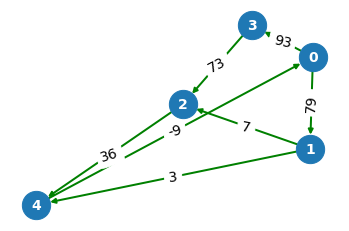

In [360]:
graph, n = instance_generator(5)
dist = bellman_ford(graph, 5, len(graph), n, True, False)
printArrBellman(dist, 5)

>**La opción verbose mostrará la ejecución del algoritmo paso a paso**

In [361]:
dist = bellman_ford(graph, 5, len(graph), n, False, True)
printArrBellman(dist, 5)

Nodo fuente: 1
Distancias mínimas con "0" arcos considerados
   0   1   2   3   4
 inf   0 inf inf inf

Se actualizó la mínima distancia hasta el nodo: 2
Considerando la mínima distancia hasta el nodo 1 = 0
más el peso del arco entre estos = 7

Se actualizó la mínima distancia hasta el nodo: 4
Considerando la mínima distancia hasta el nodo 1 = 0
más el peso del arco entre estos = 3

Se actualizó la mínima distancia hasta el nodo: 0
Considerando la mínima distancia hasta el nodo 4 = 3
más el peso del arco entre estos = -9

Se actualizó la mínima distancia hasta el nodo: 3
Considerando la mínima distancia hasta el nodo 0 = -6
más el peso del arco entre estos = 93

Distancias mínimas con "1" arcos considerados
   0   1   2   3   4
  -6   0   7  87   3

Distancias mínimas con "2" arcos considerados
   0   1   2   3   4
  -6   0   7  87   3

El algoritmo es estable:
Distancia desde el vertice fuente "1" a todos los demás vértices
   0   1   2   3   4
  -6   0   7  87   3


Si entre una iteración a otra no hubieron actualizaciones, quiere decir que el algoritmo es estable, por lo que terminará su ejecución y mostrará el vector de distancias. Por otro lado, si el algoritmo realiza actualizaciones en la última iteración, quiere decir que contiene ciclos infinitos y terminará la ejecución mostrando un mensaje por pantalla.

## **4. Correctitud**

### **Teorema**
*El algoritmo **Bellman-Ford** calcula la distancia más corta desde el vértice fuente $s$ a cualquier vértice $v\in V$ por cada $i$ arcos considerados.*

#### **Por inducción matemática**

##### **Caso base:**
**Cuando no se consideren arcos**, es decir $i = 0$.
Donde para $0$ arcos considerados, pueden ocurrir dos situaciones:

1.   Cuando $s$ y $v$ del subproblema actual son el mismo nodo, entonces para cero arcos la distancia que existe del origen a sí mismo es de coste 0. 
2.   En cambio, cuando $s$ y $v$ son dos nodos distintos, lo que ocurre al considerar 0 arcos es que estos nodos nunca podrán ser alcanzables entre sí, por lo que su coste es de **infinito**, lo mismo sucede con la distancia entre dos nodos sin conexion directa.

##### **Paso inductivo:**
Para $0 < i < V$ existirán también 2 casos para calcular la distancia mínima entre un nodo $s$ a otro $v$ con $i$ arcos considerados (denotado de esta forma $L_{i,v}$):


**1.-** Cuando la distancia mínima considerando $i-1$ arcos sea menor o igual a cualquier distancia mínima desde $s$ a un vértice intermedio $w$ en $i-1$ arcos más el peso de arco entre $w$ y $v$:
> $L_{i-1,v} ≤ min(L_{i-1,w} + dist(w,v))$

Entonces $L_{i,v}$ será igual a $L_{i-1,v}$, que por inducción $L_{i-1,v}$ fue un valor calculado con anterioridad y almacendado en en una lista de soluciones.

**2.-** Cuando por el contrario:
> $L_{i-1,v} > min(L_{i-1,w} + dist(w,v))$

Entonces $L_{i,v}$ será $min(L_{i-1,w} + dist(w,v))$, donde cualquier valor de 
$L_{i-1,w}$ fue calculado anteriormente por inducción y el arco $dist(w,v)$ obtenido directamente del grafo.





## **5. Tiempo de ejecución**

### **Algoritmo Bellman-Ford**

#### **Teorema**
>*El algoritmo **Bellman-Ford** tiene un tiempo de ejecución $O(V·E)$.*

Para calcular el tiempo de ejecución del algoritmo se utilizará la siguiente fórmula obtenida del libro Algorithms Illuminated (Parte 4, página 107):

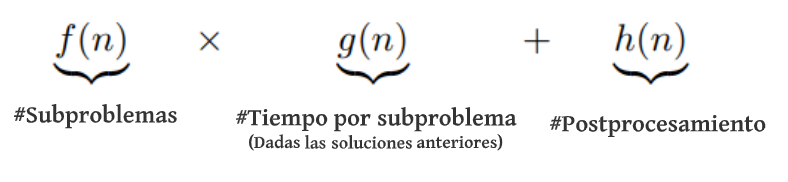

Entonces para obtener el tiempo de ejecución del algoritmo $T(n)$, primeramente debemos calcular las 3 funciones anteriores:

1.   $f(n)$: Se refiere a la cantidad de subproblemas en resolver. Para un grafo de $V$ vertices y $E$ arcos, la cantidad de subproblemas se define para cada arco considerado que será no más de V-1 si el grafo no contiene ciclos negativos y, por cada uno de estos arcos, todas las distancias desde el vertice fuente al resto de nodo lo que en una iteración conlleva pasar por todos los arcos involucrados en el grafo. A lo anterior se le conoce como aplicar la función relajación a cada arco una cantidad de V-1 veces

2.   $g(n)$: Se refiere al tiempo estimado por resolver cada subproblema. Lo que en este caso, para resolver cada uno se debe aplicar la función de relajación a su arco, siendo esta de complejidad $O(1)$ ya que la implementación es dinámica y la función utiliza la solución de la iteración actual y compararla con una nueva solución candidata.

3.   $h(n)$: Se refiere al tiempo de ejecución en procesar la solución. En este caso es despreciable el valor de esta función, ya que buscamos una cota superior para el algoritmo y lo calculado es de orden $O(1)$ en instrucciones para almacenar la solución dinámicamente.

Reemplazando obtendremos:
>$T(n) = \sum_{j=1}^{V}\sum_{i=1}^{E}·c$
>
>$T(n) = c·\sum_{j=1}^{V}E$
>
>$T(n) = c·VE$
>
>$T(n) = O(VE)$





### **Algoritmo Dijkstra**

#### **Teorema**
>*El algoritmo **Dijkstra** tiene un tiempo de ejecución $O(E + Vlog(V))$.*

Para calcular el tiempo de ejecución del algoritmo se analizarán los procedimientos y **estructuras** involucrados en este:

**1.-** Se obtienen los nodos ordenados **por su coste de llegar a él** de menor a mayor, este paso se realiza utilizando un montículo binario, donde sus operaciones se realizan en orden $O(log(n))$, con $n$ como la cantidad de datos en la estructura, y en vista de que el algoritmo necesita obtener todos los nodos, realiza $V$ veces operaciones de $O(log(V))$, la complejidad resultante es de $O(Vlog(V))$

**2.-** Además por cada vértice visitado, debe evaluar el arco de menor peso hacia un nodo adyacente a este. Si se evaluan todos los arcos adyacentes de cada nodo eso quiere decir que se recorrerán todos los arcos del grafo.

Entonces para obtener la tiempo total del algoritmo $T(n)$ se calculará la siguiente fórmula:
>$T(n) = c·E + V·O(log(V))$
>
>$T(n) = c·E + c·V·log(V)$
>
>$T(n) = c·(E + Vlog(V))$
>
>$T(n) = O(E + Vlog(V))$



## **6. Experimentos**

### **6.1. Tiempo de ejecución en función del tamaño de entrada (Bellman-Ford)**

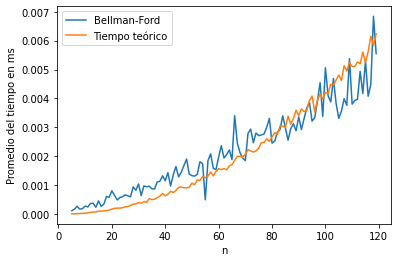

In [395]:
x = []
y = []
y_teo = []

for n in range(5,120):
  graph, s = positive_instance_generator(n)
  prom = 0

  for j in range(25):
    tiempo = repeat(setup="from __main__ import bellman_ford", stmt=f"bellman_ford({graph},{n},{len(graph)},{s})", repeat=1, number=10)
    prom += tiempo[0]
  prom = prom/25

  x.append(n)
  y.append(prom)
  y_teo.append(n*len(graph)/5000000) #La escala de tiempo es a 5 millones


plt.plot(x,y)
plt.plot(x,y_teo)
plt.legend(["Bellman-Ford", "Tiempo teórico"])
plt.xlabel('n')
plt.ylabel('Promedio del tiempo en ms')
plt.show()


Por lo que podemos observar lo calculado en el tiempo de ejecución es correcto, solo hubo que ajustar la escala dividiendo $(VE)$ en 5 millones, porque esa escala es en la que tardan los subproblemas en resolverse por el entorno de ejecución, además cabe recalcar que los peaks como se comprobó anteriormente tienen relación a procesos externos al algoritmo.

### **6.2. Algoritmo Bellman-Ford v/s Dijkstra (Tiempo de ejecución)**

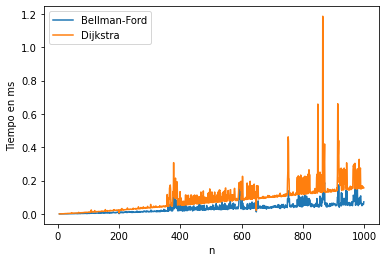

In [365]:
x=[]
y_d = []
y_b = []

for n in range(5,1000):
  graph, s = positive_instance_generator(n)

  dijkstraGraph = graph_to_dijkstraGraph(graph, n)
  
  #la función repeat está ejecutando 10 veces Bellman-Ford retorna el mejor tiempo obtenido.
  t_b = repeat(setup="from __main__ import bellman_ford", stmt=f"bellman_ford({graph},{n},{len(graph)},{s})", repeat=1, number=10)

  #la función repeat está ejecutando 10 veces Dijkstra retorna el mejor tiempo obtenido.
  t_d = repeat(setup="from __main__ import dijkstra", stmt=f"dijkstra({dijkstraGraph},{n},{s})", repeat=1, number=10)

  x.append(n)
  y_b.append(t_b)
  y_d.append(t_d)

plt.plot(x,y_b)
plt.plot(x,y_d)
plt.legend(["Bellman-Ford", "Dijkstra"])

plt.xlabel('n')
plt.ylabel('Tiempo en ms')
plt.show()

Podemos observar que el algoritmo de Bellman-Ford supera en timepo de ejecución al de Dijkstra, esto puede deberse a las optimizaciones realizadas al primero, en las que la ejecución era detenida en caso de encontrar la solución en pocas iteraciones, dándose pocas veces los peores casos por el instanciador de grafos. Además que el instanciador no agrega demasiados arcos siendo este valor el punto fuerte del algoritmo de Dijkstra ya que, recordando la complejidad de ambos algoritmos, el de Bellman-Ford podría verse mucho más influenciado por los arcos que el de Dijkstra, y debido a que existe un límite de arcos, es que después de cierto punto solo se vuelve una constante, compitiendo un algoritmo de complejidad lineal $O(V)$ que es el de Bellman contra el de Dijkstra que es $O(Vlog(V))$.